In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import tensorflow as tf
import keras.layers as layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re
import string
import numpy as np
import pandas as pd

2022-12-15 17:55:56.053834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# experiment name
name = 'both_generated_using_correct_names_40k'

# Dataset

In [4]:
df = pd.read_csv(f"data/{name}.csv")
print(df.shape)
df.sample(10)

(40000, 2)


,Name,class
88,سيعد ايه واجد,1.0
14158,لارا رواء اسلم,1.0
8162,روحيه سالمان طعيمة,1.0
35386,رضضاعررفاات العنان قابل,0.0
18319,الباسل ناحى نعم,1.0
29742,ارجاء أرجوك لحب,0.0
33209,مستر الأحاسيس ياليت,0.0
39376,الششتاوى يباو نوران,0.0
17206,زغلول عبدالرخمن فاتانات,1.0
32873,هجره باارين الغناء,0.0


In [5]:
# max number of words per name
df['Name'].str.split().str.len().max()

3

In [6]:
df.head(5)

,Name,class
0,ميلار الليل بلاسى,1.0
1,الغالى لبا بركات,1.0
2,عبداالمتجلى السيدالسعيد رينادا,1.0
3,ونيس سعا عبدالروف,1.0
4,محمدحسن عاليا عليه,1.0


In [7]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Name,class
0,فاهم الشوادفى كحيل,1.0
1,علوانى دميانة الصافى,1.0
2,البازالسيد جميان المنتصر,1.0
3,الناشر اقبل االششيخخ,0.0
4,وازن وحيد نيره,1.0


## Document Preprocessing

In [8]:
# adding start and end tokens
names = ['<SOS> ' + x + ' <EOS>' for x in df['Name'].tolist()]
corpus = " ".join(names)
labels = df['class'].tolist()
corpus[:1000]

'<SOS> فاهم الشوادفى كحيل <EOS> <SOS> علوانى دميانة الصافى <EOS> <SOS> البازالسيد جميان المنتصر <EOS> <SOS> الناشر اقبل االششيخخ <EOS> <SOS> وازن وحيد نيره <EOS> <SOS> سأجد الفرس البلكونة <EOS> <SOS> العميرى العابسى انس <EOS> <SOS> الحاربى بكير الشرنوبى <EOS> <SOS> والتصميم هادنش الحلو <EOS> <SOS> ععز زوبهه اييادالدين <EOS> <SOS> كر حسنين زاهد <EOS> <SOS> فاطة رشيد روهيفاء <EOS> <SOS> السياحيه حسابي ملقتش <EOS> <SOS> رروححى رسسلان الهنندااوى <EOS> <SOS> السسعببدااحمد نيرففاننه الباششا <EOS> <SOS> الخريطة نععمةااللله لاجع <EOS> <SOS> المعصراوى عبدالواجد باشا <EOS> <SOS> ريان الدميياطى المسيرىى <EOS> <SOS> البشير هوانم القعقاع <EOS> <SOS> التوضيح المكالمات قدري <EOS> <SOS> طعيمة كرستين الدمرانى <EOS> <SOS> وواليد هانري سادن <EOS> <SOS> قاسم لبا الزواوى <EOS> <SOS> مكة الموجى راغداء <EOS> <SOS> فتكون ززيااده ام <EOS> <SOS> اليوميات تسليمي المساحه <EOS> <SOS> ندا هلا ليبفي <EOS> <SOS> تتداخل محزن طعىام <EOS> <SOS> السعاده مسك لفتاة <EOS> <SOS> قلصبىا هنري لهال <EOS> <SOS> اناء حسينى الباسل

## Tokenization 

In [9]:
tokenize = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>", filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', lower=False)
tokenize.fit_on_texts(names)
x = tokenize.texts_to_sequences(names)
max_len = 6
x = tf.keras.utils.pad_sequences(x, maxlen=max_len, padding='post')
total_words = len(tokenize.word_index)+1
print(f"Total Words: {total_words}")
print("Example of a Sequence")
print(x[:3])
print("Some Tokens")
print(list(tokenize.word_index)[:10])

Total Words: 14782
Example of a Sequence
[[   2  548 2257  549    3    0]
 [   2 1375 3457  705    3    0]
 [   2 1662 1117 1663    3    0]]
Some Tokens
['<UNK>', '<SOS>', '<EOS>', 'جميلة', 'ختام', 'فاضل', 'خاطر', 'سنا', 'ندا', 'العز']


## Splitting data and making dataset 

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(x, df['class'].values, test_size=.2, random_state=23)
print("Train and Validation sizes")
len(x_train), len(x_valid), len(y_train), len(y_valid)

Train and Validation sizes


(32000, 8000, 32000, 8000)

In [11]:
y_train.sum(), y_valid.sum()

(15971.0, 4029.0)

In [12]:
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
ds_valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(128)

2022-12-15 17:56:02.241906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 17:56:02.275492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 17:56:02.275879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 17:56:02.276457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [13]:
for x,y in ds_train.take(1):
    print(x[:2], y[:2])

tf.Tensor(
[[    2  2501 11153  3460     3     0]
 [    2  9459    17  9460     3     0]], shape=(2, 6), dtype=int32) tf.Tensor([0. 0.], shape=(2,), dtype=float64)


# Build and Train a Model: 

In [48]:
vocab_size = total_words
embedding_dim = 64
sequence_length = max_len

In [49]:
model = tf.keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim),
  layers.Dropout(0.4),
  layers.GlobalAveragePooling1D(),
  layers.Dense(1)],
  )

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          946048    
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 946,113
Trainable params: 946,113
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy())

In [51]:
early_stopping = EarlyStopping(patience=2, restore_best_weights=True, verbose=True)
epochs = 20
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/20
250/250 [==============================] - 1s 4ms/step - loss: 0.6484 - binary_accuracy: 0.5028 - val_loss: 0.5561 - val_binary_accuracy: 0.5159
Epoch 2/20
250/250 [==============================] - 1s 4ms/step - loss: 0.4077 - binary_accuracy: 0.8455 - val_loss: 0.3049 - val_binary_accuracy: 0.9565
Epoch 3/20
250/250 [==============================] - 1s 4ms/step - loss: 0.2116 - binary_accuracy: 0.9775 - val_loss: 0.1910 - val_binary_accuracy: 0.9679
Epoch 4/20
250/250 [==============================] - 1s 4ms/step - loss: 0.1336 - binary_accuracy: 0.9840 - val_loss: 0.1459 - val_binary_accuracy: 0.9693
Epoch 5/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0980 - binary_accuracy: 0.9871 - val_loss: 0.1243 - val_binary_accuracy: 0.9706
Epoch 6/20
250/250 [==============================] - 1s 3ms/step - loss: 0.0769 - binary_accuracy: 0.9895 - val_loss: 0.1123 - val_binary_accuracy: 0.9704
Epoch 7/20
250/250 [==============================] - 1s 3ms/ste

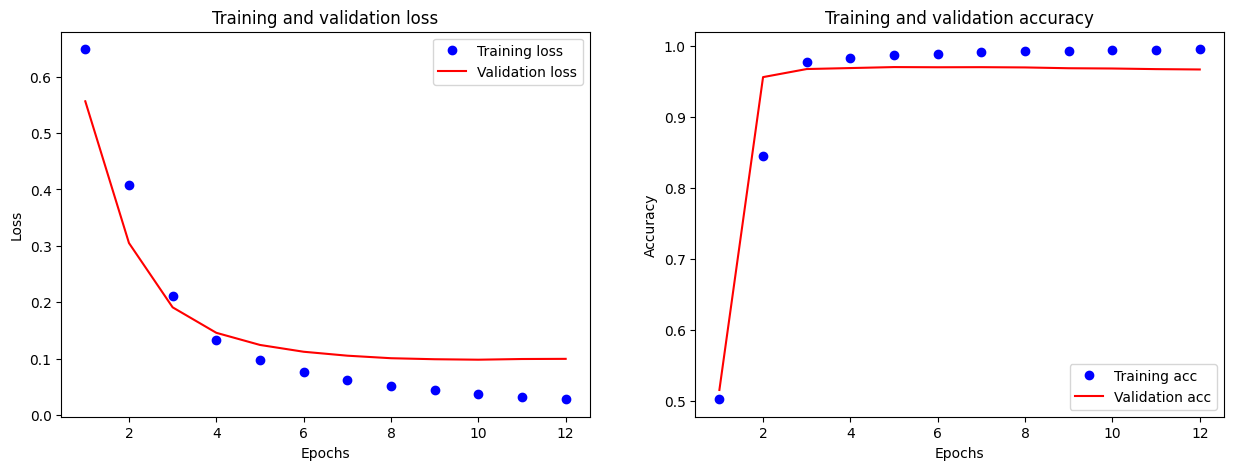

In [52]:
from utils import plot_history
plot_history(history.history)

### Test Examples 

In [53]:
#new
example = '<sos> ' + "معاذ طه عوض" + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 50ms/step


array([[0.9980884]], dtype=float32)

In [54]:
#new
example = "باسم وحيد السيد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 31ms/step


array([[0.99994254]], dtype=float32)

In [55]:
#new
example = "شسي شسي شسي"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 35ms/step


array([[0.6978209]], dtype=float32)

In [56]:
#new
example = "باسمم وحةد السد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 37ms/step


array([[0.09914164]], dtype=float32)

In [57]:
#new
example = "مريم محمد محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 36ms/step


array([[0.99992776]], dtype=float32)

In [58]:
#new
example = "محمد مريم محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 60ms/step


array([[0.99992776]], dtype=float32)

In [59]:
#new
example = "مريم محمد على"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 33ms/step


array([[0.9999875]], dtype=float32)

In [60]:
#new
example = "محمد طه عوض"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 30ms/step


array([[0.9998092]], dtype=float32)

In [61]:
#new
example = "فوزىىى محسمد شنش"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 31ms/step


array([[0.6978209]], dtype=float32)

In [62]:
#new
example = "دزيادد عبت محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 31ms/step


array([[0.98463804]], dtype=float32)

In [63]:
#new
example = "محمد طه عوض لاشين"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 49ms/step


array([[0.9999827]], dtype=float32)

In [64]:
#new
example = "زيادي ممسسيشي شسيسيد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 29ms/step


array([[0.6978209]], dtype=float32)

# Saving and loading the trained model 

In [93]:
model.save(f'models/{name}_model.h5', )

In [94]:
new_model = tf.keras.models.load_model(f'models/{name}_model.h5')
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          462912    
                                                                 
 dropout_3 (Dropout)         (None, None, 32)          0         
                                                                 
 global_average_pooling1d_3   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 462,945
Trainable params: 462,945
Non-trainable params: 0
_________________________________________________________________


## Saving and loading the tokenizer

In [95]:
import pickle

# saving
with open(f'models/{name}tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenize, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open(f'models/{name}tokenizer.pickle', 'rb') as handle:
    new_tokenizer = pickle.load(handle)

In [96]:
#new
example = "محمد طه عوض لاشين"
example = '<sos> ' + example + ' <eos>'
example_vect = new_tokenizer.texts_to_sequences([example])
tf.nn.sigmoid(new_model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 82ms/step


array([[0.9961933]], dtype=float32)